# Developing of online ARIMA

In [79]:
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta
import os
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats, signal
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import warnings
from time import time

warnings.filterwarnings('ignore')
%matplotlib inline

plt.rcParams['figure.figsize'] = 12, 6

In [80]:
def save(name='', fmt='png'):
    pwd = os.getcwd()
    iPath = './pictures_ARIMA_dataset2/'
    if not os.path.exists(iPath):
        os.mkdir(iPath)
    os.chdir(iPath)
    plt.savefig('{}.{}'.format(name, fmt), fmt='png', dpi=300, bbox_inches='tight')
    os.chdir(pwd)
    
def single_point_errors(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs(y_pred / y_true - 1)) * 100
    rmspe = np.sqrt(np.mean(np.abs(y_pred / y_true - 1)**2)) * 100
    return np.array([rmse, mae, mape, rmspe])

def time_series_errors(y_true, y_pred):
    err = np.zeros((y_true.shape[0], 4))
    for i in range(y_true.shape[0]):
        err[i,:] = single_point_errors(y_true[:i+1], y_pred[:i+1])
    return pd.DataFrame(err, columns=["rmse", "mae", "mape", "rmspe"])

def time_series_errors_necum(y_true, y_pred):
    err = np.zeros((y_true.shape[0], 4))
    for i in range(y_true.shape[0]):
        err[i,:] = single_point_errors(y_true[i], y_pred[i])
    return pd.DataFrame(err, columns=["rmse", "mae", "mape", "rmspe"])

def getNplot_errors(y, pred,name='template'):
    err = np.zeros((y.shape[0], 4))
    for i in range(y.shape[0]):
        err[i,:] = single_point_errors(y[:i+1], pred[:i+1])
          
    fig=plt.figure(figsize=(14,9))   
        
    ax1 = plt.subplot(211)
    ax1.plot(pred, lw=1, label="predicted")
    ax1.plot(y, lw=1, label="true")
    ax1.legend(fontsize=14)
    ax1.set_ylabel("value", fontsize=14)
    ax1.set_xlabel("time", fontsize=14)
    ax1.set_title(name, fontsize=16)
    
    ax2 = plt.subplot(223)
    ax2.plot(err[:,0], label="RMSE")
    ax2.plot(err[:,1], label="MAE")
    ax2.legend(fontsize=14)
    ax2.set_ylabel("error", fontsize=14)
    ax2.set_xlabel("time", fontsize=14)
    
    ax3 = plt.subplot(224)
    ax3.plot(err[:,3], label="RMSPE")
    ax3.plot(err[:,2], label="MAPE")
    ax3.legend(fontsize=14)
    ax3.set_ylabel("error, %", fontsize=14)
    ax3.set_xlabel("time", fontsize=14)
    
    #save(name)
    #return pd.DataFrame(err, columns=["rmse", "mae", "mape", "rmspe"])


#### Let's write function for ploting timing graphs and caculating of the means

In [81]:
def timing(fit_time,pred_time):
    print('Mean fitting time = {1:.{0}f}\nMean predicting time = {2:.{0}f}'.format(4,np.mean(fit_time),np.mean(pred_time)))
    plt.figure(figsize=(10,8))

    plt.subplot(211)
    plt.plot(fit_time,label='fitting time')
    plt.ylabel('time, sec')
    plt.xlabel('Number of iteration')
    plt.legend()

    ax = plt.subplot(212)
    plt.plot(pred_time,label='predicting time')
    plt.ylabel('time, sec')
    plt.xlabel('Number of iteration')
    plt.legend()


# Explore the Data.
## Dataset #2: 

In [7]:
data=pd.read_csv("international-airline-passengers.csv",index_col=['Month'],parse_dates=['Month'])
data.columns=['passengers in thousands']

date_list = [pd.datetime.strptime("1949-01", "%Y-%m") + relativedelta(months=x) for x in range(len(data))]
data_new = pd.DataFrame(data['passengers in thousands'].values,index=date_list,columns=['passengers in thousands'])

train, test = train_test_split(data_new, shuffle=False, test_size=0.2)
print('Data lengh: {}, train dataset lengh: {}, test dataset lengh: {}'.format(len(data),len(train),len(test)))

Data lengh: 144, train dataset lengh: 115, test dataset lengh: 29


Text(0.5,1,'International airline passengers: monthly totals in thousands')

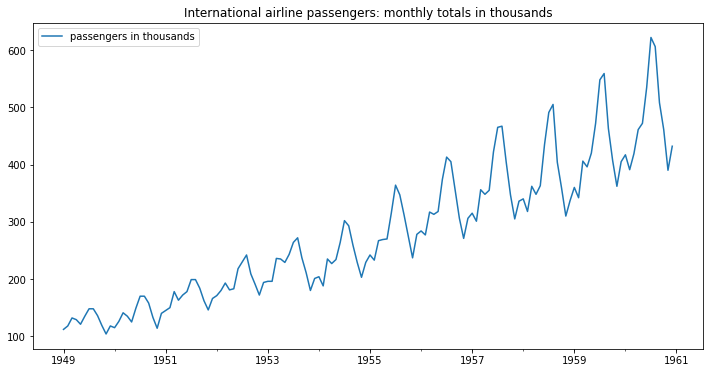

In [82]:
data_new.plot()
plt.title('International airline passengers: monthly totals in thousands')

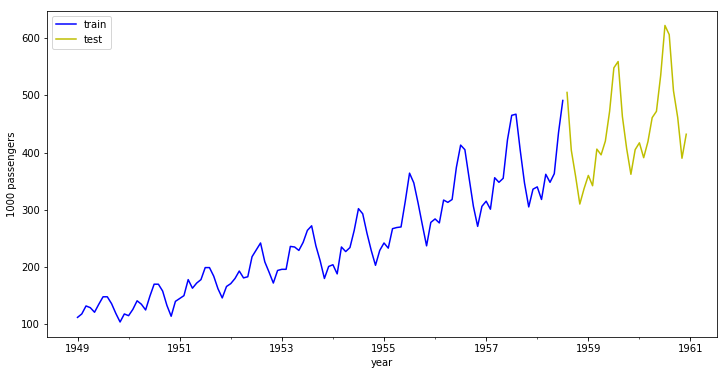

In [83]:
train['passengers in thousands'].plot(color='b',label='train')
test['passengers in thousands'].plot(color='y',label='test')
plt.ylabel('1000 passengers')
plt.xlabel('year')
plt.legend()
save('isx2')
plt.show()


### We estimate power spectral density using Welch's method to estimate main harmonics

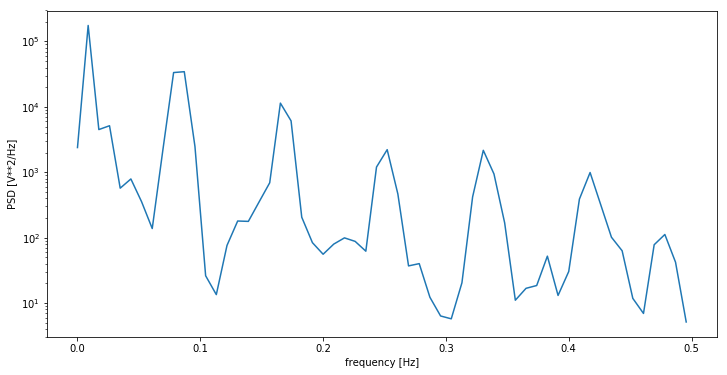

In [84]:
f, Pxx_den = signal.welch(train['passengers in thousands'],nperseg=len(train['passengers in thousands']))
plt.semilogy(f, Pxx_den) 
plt.xlabel('frequency [Hz]') 
plt.ylabel('PSD [V**2/Hz]') 
save('2welch')
plt.show()

In [85]:
print('''We estimate power spectral density using Welch's method (in descending order):''')
j=1
for i in Pxx_den.argsort()[::-1][:4]:
    print('{}. For period {} months scaled PSD = {}'.format(j,round(1/f[i],3),round(Pxx_den[i]/np.max(Pxx_den),3)))
    j+=1

We estimate power spectral density using Welch's method (in descending order):
1. For period 115.0 months scaled PSD = 1.0
2. For period 11.5 months scaled PSD = 0.196
3. For period 12.778 months scaled PSD = 0.191
4. For period 6.053 months scaled PSD = 0.065


Intermediate conclusion: Using Welch's method and visual analysis we choose 12 months as main seasonal component

### Advanced Dickey–Fuller (ADF) test for stationarity

In [86]:
print("Dickey–Fuller criterion: p = {0}, used lag = {1}".format(round(sm.tsa.stattools.adfuller(train['passengers in thousands'])[1],4)
                                                              ,sm.tsa.stattools.adfuller(train['passengers in thousands'])[2]))

Dickey–Fuller criterion: p = 0.9171, used lag = 13


ADF test confirms the non-stationarity hypothesis with a high degree of confidence. Let us find seasonal difference and conduct ADF test again:

In [87]:
train['CO2 [ppm]_sdiff'] = train['passengers in thousands'] - train['passengers in thousands'].shift(12)
print("Dickey–Fuller criterion: p = {0}, used lag = {1}".format(round(sm.tsa.stattools.adfuller(train['CO2 [ppm]_sdiff'][12:])[1],6)
                                                              ,sm.tsa.stattools.adfuller(train['CO2 [ppm]_sdiff'][12:])[2]))

Dickey–Fuller criterion: p = 0.013231, used lag = 2


ADF test confirms the non-stationarity hypothesis with a low degree of confidence. Let us find first difference of the time series to delete trend from the data:

In [88]:
train['CO2 [ppm]_sdiff_diff'] = train['CO2 [ppm]_sdiff'] - train['CO2 [ppm]_sdiff'].shift(1)
print("Dickey–Fuller criterion: p = {0}, used lag = {1}".format(round(sm.tsa.stattools.adfuller(train['CO2 [ppm]_sdiff_diff'][13:])[1],6)
                                                              ,sm.tsa.stattools.adfuller(train['CO2 [ppm]_sdiff_diff'][13:])[2]))

Dickey–Fuller criterion: p = 0.0, used lag = 0


ADF test rejects the non-stationarity hypothesis.

### Selection of the best model

In [89]:
ps = range(1, 4)
#Number of times we took first differences
d=1
qs = range(1, 4)
Ps = range(0, 2)
#Number of times we took seasonal differences
D=1
Qs = range(0, 2)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

results = []
best_aic = float("inf")

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        start = time()
        model=sm.tsa.statespace.SARIMAX(train['passengers in thousands'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)
                                       ).fit(disp=-1)
        stop = time()
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic,stop-start])
    
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic', 'time']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic      time
24  (3, 2, 0, 0)  753.232736  0.435890
10  (1, 3, 1, 0)  753.974947  0.634302
9   (1, 3, 0, 1)  753.994887  0.569477
8   (1, 3, 0, 0)  754.177641  0.157580
20  (3, 1, 0, 0)  754.434556  0.178520


In [90]:
#best model orders:
order = (1,1,3)
seasonal_order = (0,1,0,12)

Let us check residuals of the best model (chosen by the best AIC):

Student criterion: p=0.786505
Dickey–Fuller criterion: p=8.055599729146933e-17


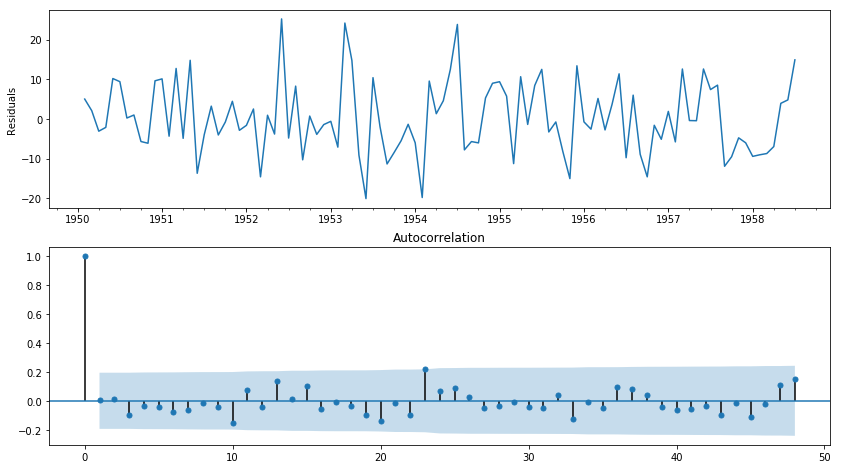

In [91]:
plt.figure(figsize=(14,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values[13:].squeeze(), lags=48, ax=ax)

print("Student criterion: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey–Fuller criterion: p={}".format(sm.tsa.stattools.adfuller(best_model.resid[13:])[1]))
save('5_avtocorrelation and residuals')

As we see, residuals are non-stationary (ADF test), non-autocorrelated (correlogram) and unbiased (Student criterion). Let us check results of our model:

In [92]:
train_2 = train[['passengers in thousands']]

Predicting time = 0.012965679168701172


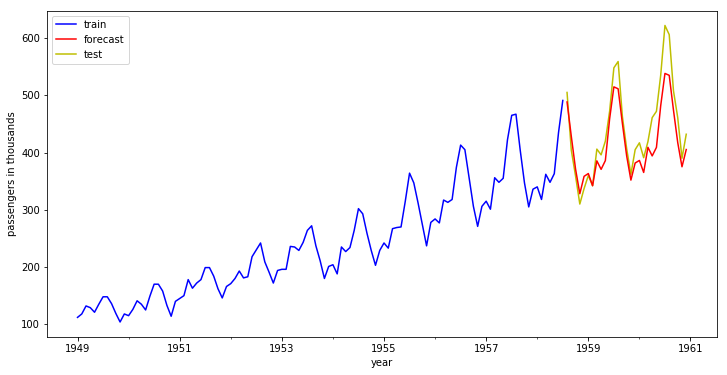

In [93]:
train_2 = train[['passengers in thousands']]
date_list = [pd.datetime.strptime("1958-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(len(test)+1)]
future = pd.DataFrame(index=date_list, columns=train_2.columns)
train_2 = pd.concat([train_2, future])

start = time()
forecast = best_model.forecast(len(test))
stop = time()
train_2['forecast'] = forecast
print('Predicting time = {}'.format(stop-start))

train_2['passengers in thousands'].plot(color='b',label='train')
train_2['forecast'].plot(color='r',zorder=20)
test['passengers in thousands'].plot(color='y',label='test')

plt.ylabel('passengers in thousands')
plt.xlabel('year')
plt.legend()
save(name='6_simple_arima_longterm')
plt.show()

### MSE of a long-term forecast for ordinary model (without refitting)

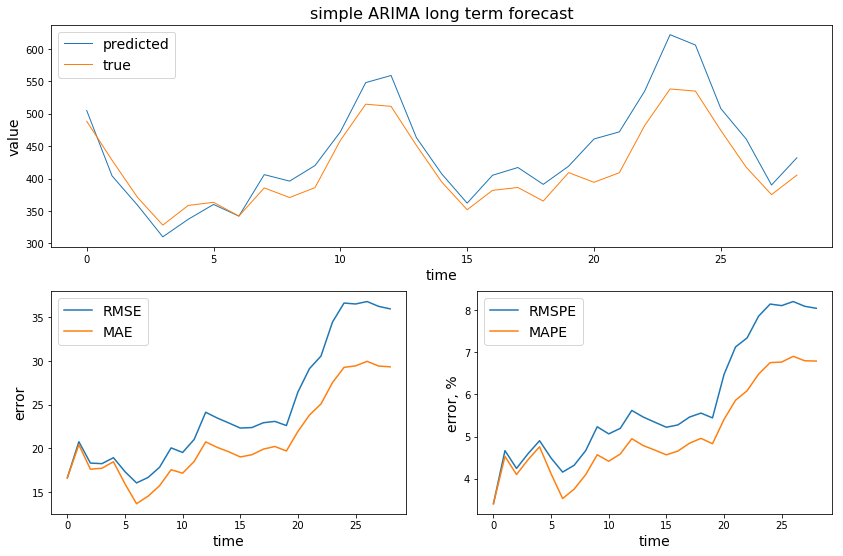

In [94]:
getNplot_errors(forecast.values, test['passengers in thousands'].values,name='simple ARIMA long term forecast')

#### For further research let's define errors arrays

In [95]:
#error for 1 point forecast:
error_1p = []
#error for len(test) (multiple) points forecast:
error_mp = []

### First online ARIMA algorithm (adding each new point to train and refitting)

#### One point forward forecasting

In [96]:
history=[x for x in train['passengers in thousands'].values]
predictions = list()
fit_time, pred_time = [],[]
for t in range(len(test)):
    start = time()
    model = sm.tsa.statespace.SARIMAX(history, order=order, 
                                        seasonal_order=seasonal_order
                                       ).fit(disp=0)
    stop = time()
    fit_time.append(stop-start)
    
    start = time()
    output = model.forecast()
    stop = time()
    pred_time.append(stop-start)
    
    yhat = output[0]
    predictions.append(yhat)
    obs = test.values[t]
    history.append(obs)
    
error_1p.append(mean_squared_error(test.values, predictions))
print('Test MSE: %.5f' % error_1p[-1])

Test MSE: 334.47242


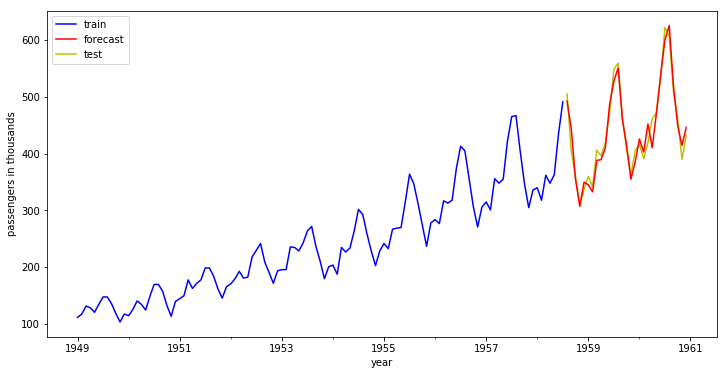

In [97]:
train_ = train[['passengers in thousands']]
date_list = [pd.datetime.strptime("1958-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(len(test)+1)]
future = pd.DataFrame(index=date_list, columns=train_2.columns)
train_ = pd.concat([train_, future])
train_['forecast'] = pd.DataFrame(index=forecast.index,data=predictions)

train_['passengers in thousands'].plot(color='b',label='train')
train_['forecast'].plot(color='r',zorder=20)
test['passengers in thousands'].plot(color='y',label='test')

plt.ylabel('passengers in thousands')
plt.xlabel('year')
plt.legend()
save(name='8_1_onlineALL_on1_points')
plt.show()

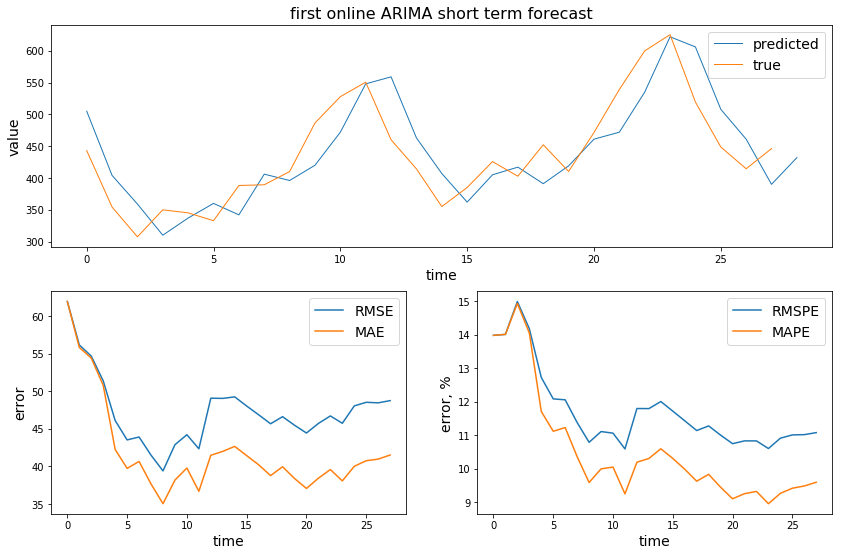

In [98]:
getNplot_errors(train_['forecast'][-len(test):].values, test['passengers in thousands'].values,name='first online ARIMA short term forecast')

Mean fitting time = 0.2139
Mean predicting time = 0.0030


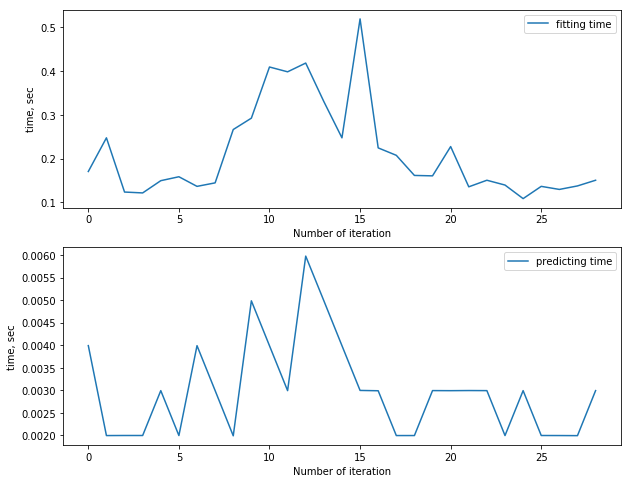

In [99]:
timing(fit_time,pred_time)
save('8_time_1_online')

#### Multiple points forward forecasting

In [100]:
history=[x for x in train['passengers in thousands'].values]
fit_time, pred_time = [],[]
for t in range(1,21):
    history_ = history[:len(train)-20+t]
    start = time()
    model = sm.tsa.statespace.SARIMAX(history_, order=order, seasonal_order=seasonal_order).fit(disp=0)
    stop = time()
    fit_time.append(stop-start)
    start = time()
    output = model.forecast(len(test))
    stop = time()
    pred_time.append(stop-start)
    #obs = test.values[t]
    #history.append(obs)
    
error_mp.append(mean_squared_error(test.values, output))
print('Test MSE: %.5f' % error_mp[-1])

Test MSE: 1333.47560


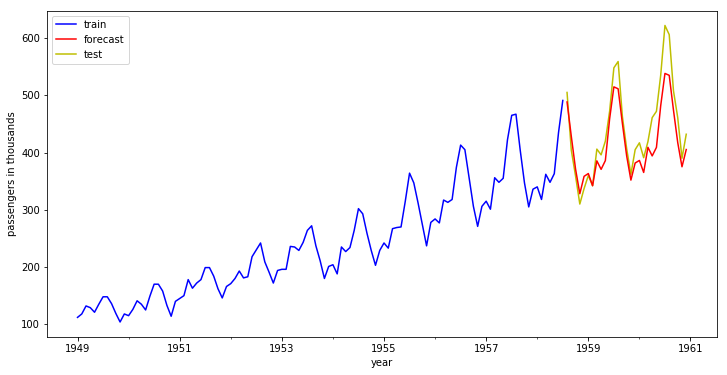

In [101]:
train_ = train[['passengers in thousands']]
date_list = [pd.datetime.strptime("1958-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(len(test)+1)]
future = pd.DataFrame(index=date_list, columns=train_2.columns)
train_ = pd.concat([train_, future])
train_['forecast'] = forecast

train_['passengers in thousands'].plot(color='b',label='train')
train_['forecast'].plot(color='r',zorder=20)
test['passengers in thousands'].plot(color='y',label='test')

plt.ylabel('passengers in thousands')
plt.xlabel('year')
plt.legend()
save(name='8_1online_long_term')
plt.show()

Mean fitting time = 0.1313
Mean predicting time = 0.0039


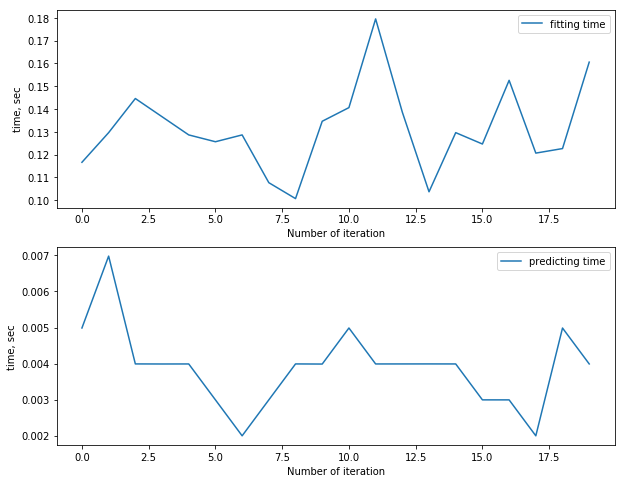

In [102]:
timing(fit_time,pred_time)
save(name='8_1online_time_long_term')

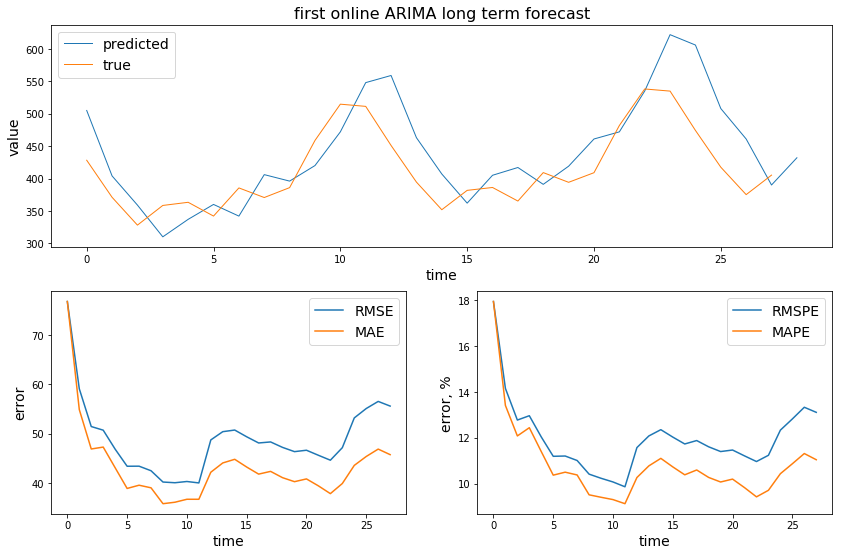

In [103]:
getNplot_errors(train_['forecast'].values[-len(test):], test['passengers in thousands'].values,'first online ARIMA long term forecast')

### Secong online ARIMA algorithm (rolling window)

#### One point forward forecasting

In [104]:
history=[x for x in train['passengers in thousands'].values]
predictions = list()
fit_time, pred_time = [],[]
for t in range(len(test)):
    start = time()
    model = sm.tsa.statespace.SARIMAX(history, order=order, 
                                        seasonal_order=seasonal_order
                                       ).fit(disp=0)
    stop = time()
    fit_time.append(stop-start)
    start = time()
    output = model.forecast()
    stop = time()
    pred_time.append(stop-start)
    yhat = output[0]
    predictions.append(yhat)
    obs = test.values[t]
    history = history[1:]
    history.append(obs)
    
error_1p.append(mean_squared_error(test.values, predictions))
print('Test MSE: %.5f' % error_1p[-1])

Test MSE: 328.92351


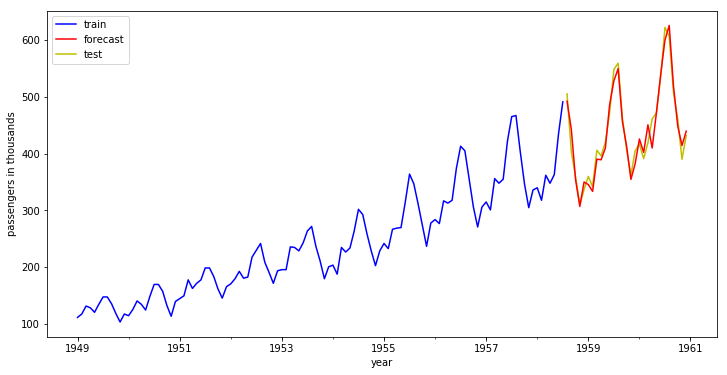

In [105]:
train_ = train[['passengers in thousands']]
date_list = [pd.datetime.strptime("1958-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(len(test)+1)]
future = pd.DataFrame(index=date_list, columns=train_2.columns)
train_ = pd.concat([train_, future])
train_['forecast'] = pd.DataFrame(index=forecast.index,data=predictions)

train_['passengers in thousands'].plot(color='b',label='train')
train_['forecast'].plot(color='r',zorder=20)
test['passengers in thousands'].plot(color='y',label='test')

plt.ylabel('passengers in thousands')
plt.xlabel('year')
plt.legend()
save(name='9_short_window_train')
plt.show()

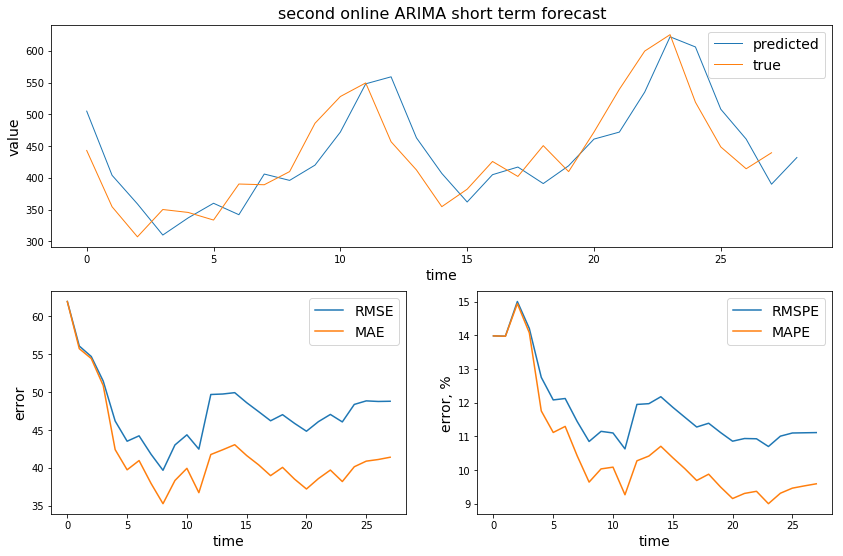

In [106]:
getNplot_errors(train_['forecast'].values[-len(test):], test['passengers in thousands'].values,'second online ARIMA short term forecast')

Mean fitting time = 0.2847
Mean predicting time = 0.0027


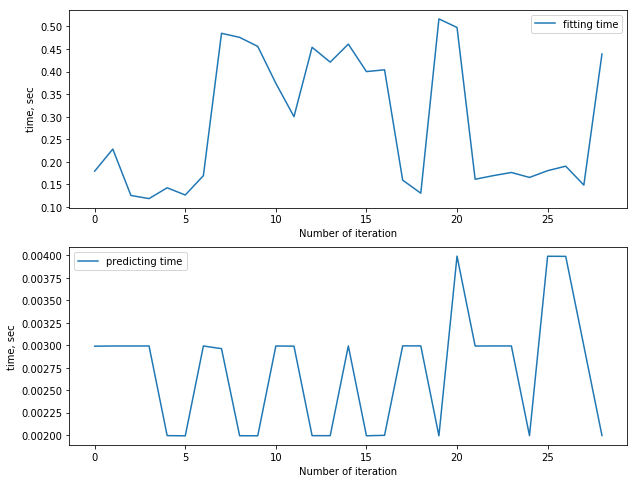

In [107]:
timing(fit_time,pred_time)
save('9_short_time')

#### Multiple points forward forecasting

In [108]:
history=[x for x in train['passengers in thousands'].values]
fit_time, pred_time = [],[]
for t in range(1,21):
    history_ = history[t:len(train)-20+t]
    start = time()
    model = sm.tsa.statespace.SARIMAX(history_, order=order, 
                                        seasonal_order=seasonal_order
                                       ).fit(disp=0)
    stop = time()
    fit_time.append(stop-start)
    start = time()
    output = model.forecast(len(test))
    stop = time()
    pred_time.append(stop-start)
    #obs = test.values[t]
    #history = history[1:]
    #history.append(obs)
    
error_mp.append(mean_squared_error(test.values, output))
print('Test MSE: %.5f' % error_mp[-1])

Test MSE: 712.79063


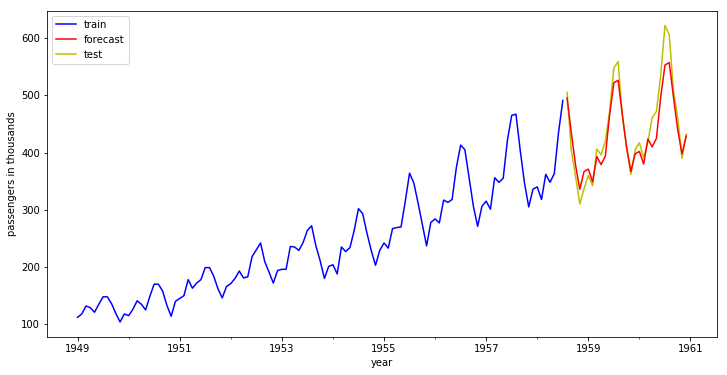

In [109]:
train_ = train[['passengers in thousands']]
date_list = [pd.datetime.strptime("1958-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(len(test)+1)]
future = pd.DataFrame(index=date_list, columns=train_2.columns)
train_ = pd.concat([train_, future])
train_['forecast'] = pd.DataFrame(index=forecast.index,data=output)

train_['passengers in thousands'].plot(color='b',label='train')
train_['forecast'].plot(color='r',zorder=20)
test['passengers in thousands'].plot(color='y',label='test')

plt.ylabel('passengers in thousands')
plt.xlabel('year')
plt.legend()
save(name='9_long_forecast')
plt.show()

Mean fitting time = 0.2410
Mean predicting time = 0.0036


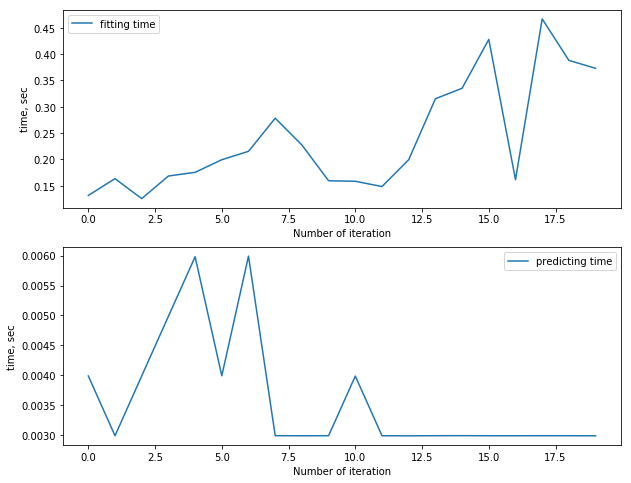

In [110]:
timing(fit_time,pred_time)
save('9_long_time_forecast')

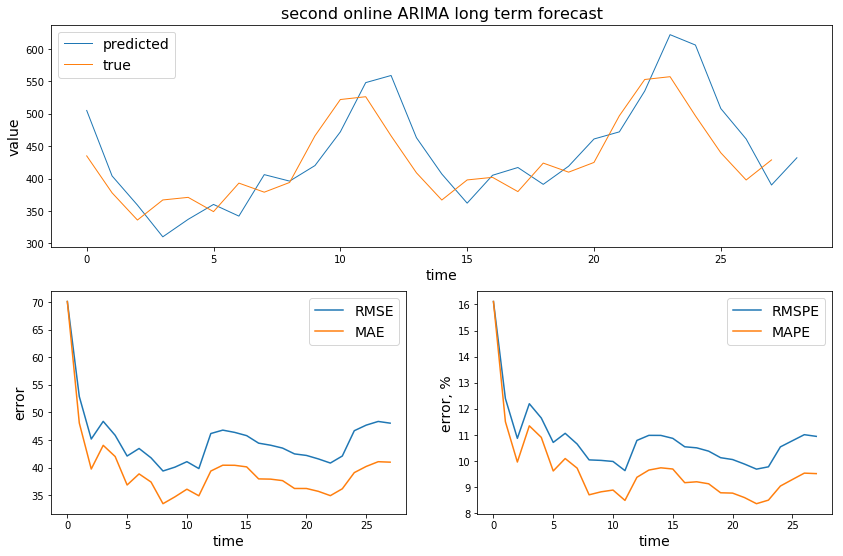

In [111]:
getNplot_errors(train_['forecast'].values[-len(test):], test['passengers in thousands'].values,'second online ARIMA long term forecast')

### Third online ARIMA algorithm (warm start)

In [112]:
def warmstart_online(data,train,test,order,seasonal_order):

    endog_train =data.iloc[:len(train):]
    ind=len(train)

    t01=time()
    mod = sm.tsa.SARIMAX(endog_train, order=order, seasonal_order=seasonal_order,enforce_stationarity=False,
                        enforce_invertibility=False)
    res = mod.fit()
    t02=time()

    # Perform forecasting for the next day
    t03=time()
    fcast1 = res.forecast(len(test))
    t04=time()

    # Save parameters and state
    a1=res.params
    a2=res.predicted_state[:, -1]
    a3=res.predicted_state_cov[:, :, -1]

    #_________________------------________________-

    predict=test.copy()
    time_list=pd.DataFrame(columns=['train time','forecast time'])

    for i in range(len(test)):    
        endog_train1p = data.iloc[ind+i-1:ind+i:]
        midnight_params, midnight_state, midnight_state_cov = a1,a2,a3

        t_1=time()
        mod = sm.tsa.SARIMAX(endog_train1p, order=order, seasonal_order=seasonal_order)
        mod.initialize_known(midnight_state, midnight_state_cov)
        res = mod.smooth(midnight_params)
        t_2=time()


        # Perform forecasting for the remaining 16 hours of the day
        t_3=time()
        predict['passengers in thousands'][i] = res.forecast(1).values[0]
        t_4=time()

        a1=res.params
        a2=res.predicted_state[:, -1]
        a3=res.predicted_state_cov[:, :, -1]

        time_list.loc[i-1]=[t_2-t_1,t_4-t_3]
    return predict, time_list
    


In [113]:
predict, time_list=warmstart_online(data_new,train,test,order,seasonal_order)

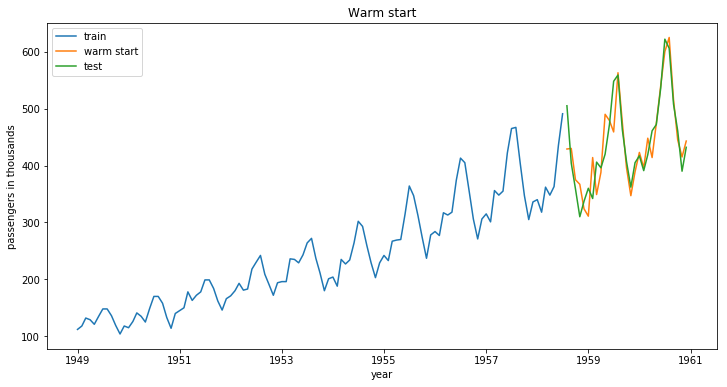

In [114]:
plt.plot(train.index,train['passengers in thousands'],label='train')
plt.plot(predict.index,predict['passengers in thousands'],label='warm start')
plt.plot(test,label='test')
plt.xlabel('year')
plt.ylabel('passengers in thousands')
plt.legend()
plt.title('Warm start')
save('10_short_test of warm start')

Mean fitting time = 0.0037
Mean predicting time = 0.0019


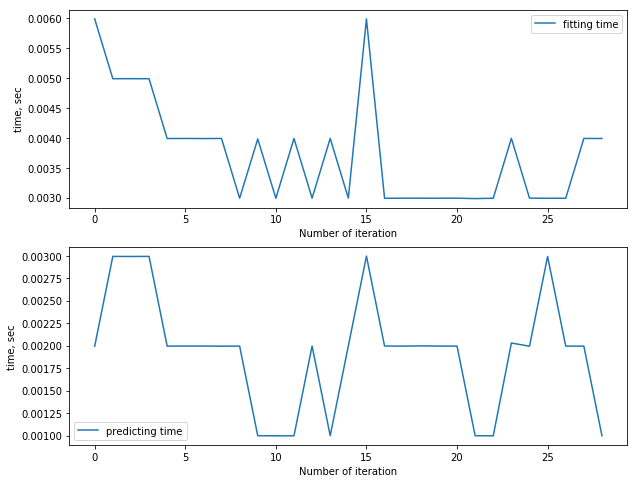

In [115]:
timing(time_list['train time'].values,time_list['forecast time'].values)
save('10_short_time warm start')

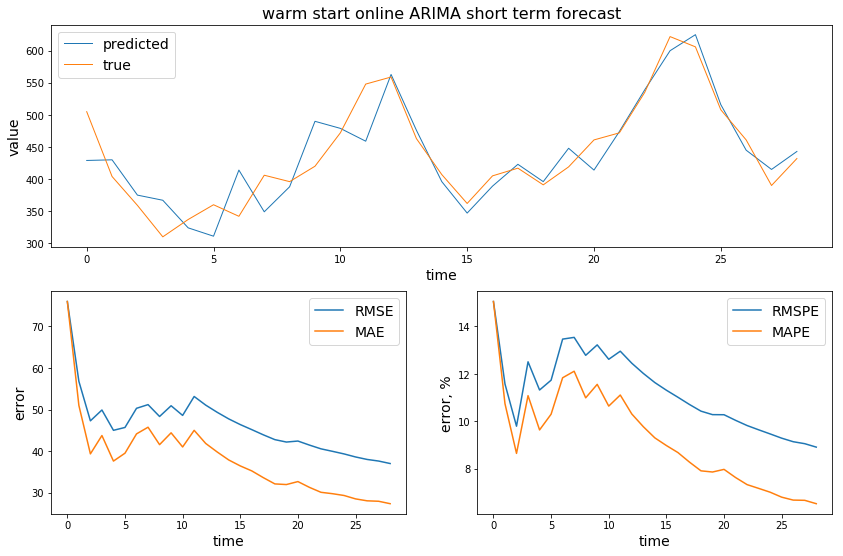

In [116]:
getNplot_errors(test.values, predict.values,'warm start online ARIMA short term forecast')

### Long term 

In [117]:
endog_train =data_new.iloc[:len(train)-20:]
ind=len(train)

t01=time()
mod = sm.tsa.SARIMAX(endog_train, order=order, seasonal_order=seasonal_order,enforce_stationarity=False,
                    enforce_invertibility=False)
res = mod.fit()
t02=time()

# Perform forecasting for the next day
t03=time()
fcast1 = res.forecast(len(test))
t04=time()

# Save parameters and state
a1=res.params
a2=res.predicted_state[:, -1]
a3=res.predicted_state_cov[:, :, -1]

#_________________------------________________-

predict=test.copy()
time_list=pd.DataFrame(columns=['train time','forecast time'])

for i in range(len(test)):    
    endog_train1p = data_new.iloc[len(train)-20:len(train):]
    midnight_params, midnight_state, midnight_state_cov = a1,a2,a3

    t_1=time()
    mod = sm.tsa.SARIMAX(endog_train1p, order=order, seasonal_order=seasonal_order)
    mod.initialize_known(midnight_state, midnight_state_cov)
    res = mod.smooth(midnight_params)
    t_2=time()


    # Perform forecasting for the remaining 16 hours of the day
    t_3=time()
    predict['passengers in thousands'][i] = res.forecast(1).values[0]
    t_4=time()

    a1=res.params
    a2=res.predicted_state[:, -1]
    a3=res.predicted_state_cov[:, :, -1]

    time_list.loc[i-1]=[t_2-t_1,t_4-t_3]
prediction=res.forecast(len(test))
    


<Figure size 864x432 with 0 Axes>

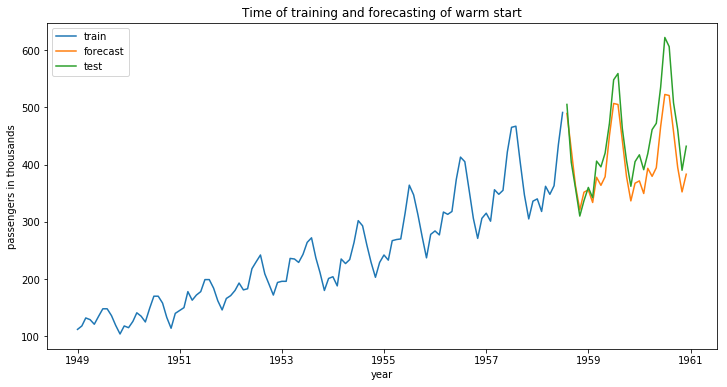

<Figure size 864x432 with 0 Axes>

In [118]:
plt.plot(train.index,train['passengers in thousands'],label='train')
plt.plot(test.index,prediction.values,label='forecast')
plt.plot(test,label='test')
plt.xlabel('year')
plt.ylabel('passengers in thousands')
plt.legend()
plt.title('Time of training and forecasting of warm start')
save('10_long_training and forecasting')
plt.figure()

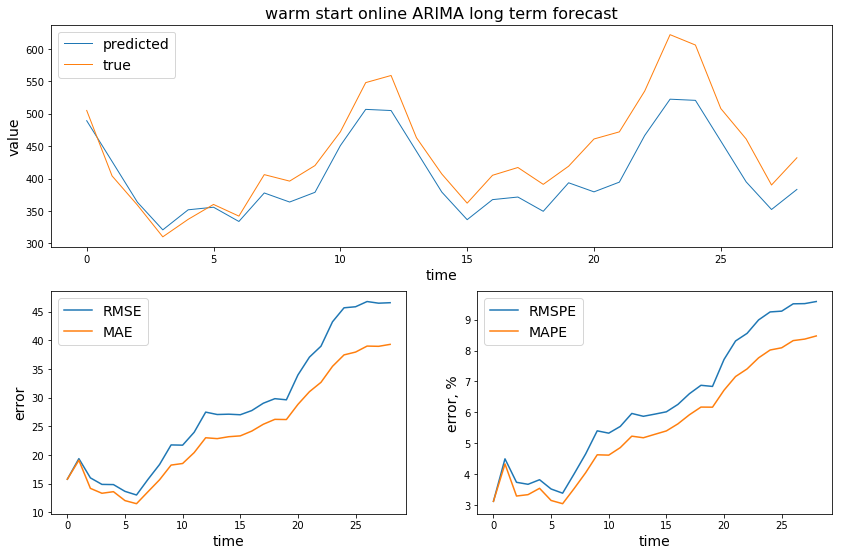

In [119]:
getNplot_errors(test.values.flatten(), prediction.values,'warm start online ARIMA long term forecast')

# True online ARIMA-OGD approach

## Long-term prognosys

In [123]:
def arima_ogd(data, mk=10, lrate=0.001, init_w=None, random_state=42, predict_size=0):
    np.random.seed(random_state)
    pred = np.zeros(data.shape[0] - mk + predict_size)
    w = np.random.rand(mk) if init_w is None else init_w
    
    data_size = data.shape[0]
    size = data_size + predict_size
    data = np.concatenate([data, np.zeros(predict_size)])
    
    for i in range(mk, size):
        pred[i-mk] = w @ data[i-mk:i]
        if i >= data_size:
            data[i] = pred[i-mk]
        
        diff = pred[i-mk] - data[i]
        w -= lrate * 2 * data[i-mk:i] * diff / np.sqrt(i+1-mk)    
    return pred, w

## One value forecasting

In [124]:
data=pd.read_csv("international-airline-passengers.csv",index_col=['Month'],parse_dates=['Month'])
data.columns=['passengers in thousands']

date_list = [pd.datetime.strptime("1949-01", "%Y-%m") + relativedelta(months=x) for x in range(len(data))]
data_new = pd.DataFrame(data['passengers in thousands'].values,index=date_list,columns=['passengers in thousands'])

train, test = train_test_split(data_new, shuffle=False, test_size=0.2)
print('Data lengh: {}, train dataset lengh: {}, test dataset lengh: {}'.format(len(data),len(train),len(test)))

Data lengh: 144, train dataset lengh: 115, test dataset lengh: 29


In [125]:
y_test = np.array(test["passengers in thousands"])
y = np.concatenate([np.array(train["passengers in thousands"]), y_test])

yd = y[1:] - y[:-1]
yds = yd[12:] - yd[:-12]

In [126]:
mk = 12
lr = 1e-5

In [127]:
%%time
pred, w = arima_ogd(yds, mk, lr)

Wall time: 2 ms


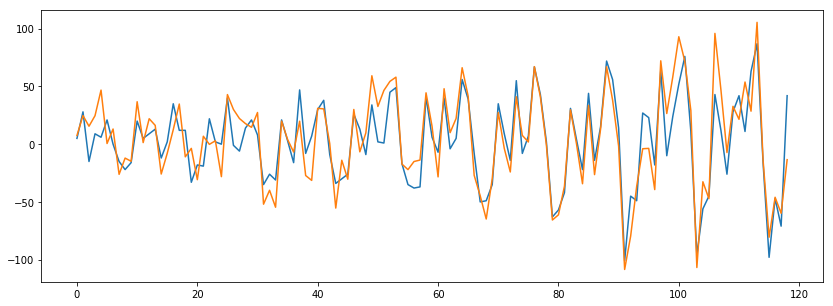

In [128]:
yd_pred = pred + yd[mk+12:]
plt.figure(figsize=(14,5))
plt.plot(yd[12+mk:])
plt.plot(yd_pred);

In [129]:
#Run this cell only once!
y_pred = yd_pred + y[mk+12:-1]
y = y[mk+12+1:]
train_size = y.shape[0] - y_test.shape[0]
test_size = y_test.shape[0]

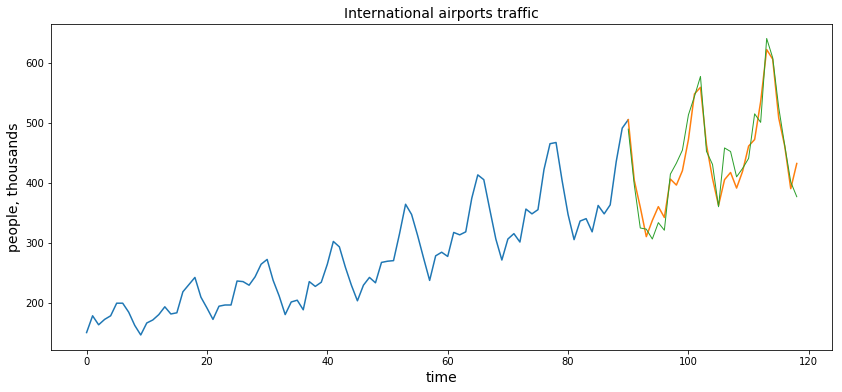

In [130]:
a = np.arange(test_size + train_size)
plt.figure(figsize=(14,6))
plt.plot(a[:train_size+1], y[:train_size+1], label="train")
plt.plot(a[-test_size:], y[-test_size:], label="test")
plt.plot(a[-test_size:], y_pred[-test_size:], lw=1, label="predicted")
plt.title("International airports traffic", fontsize=14)
plt.ylabel("people, thousands", fontsize=14)
plt.xlabel("time", fontsize=14)
save('11_short_')
plt.show()

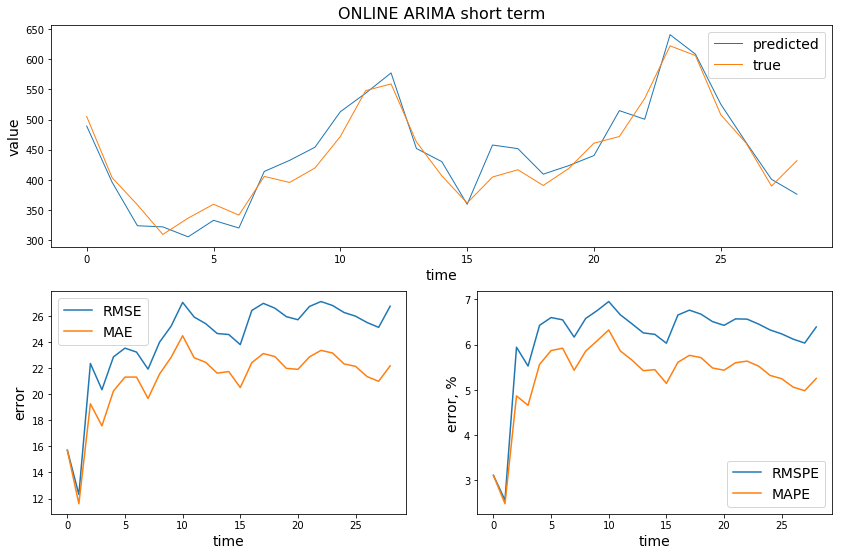

In [131]:
getNplot_errors(y[-test_size:], y_pred[-test_size:],'ONLINE ARIMA short term')

## Long time forecasting

In [132]:
y = np.array(train["passengers in thousands"])
y_test = np.array(test["passengers in thousands"])
test_size = y_test.shape[0]

yd = y[1:] - y[:-1]
yds = yd[12:] - yd[:-12]

In [133]:
mk=1
lr=1e-3

In [134]:
%%time
pred, w = arima_ogd(yds, mk, lr, predict_size=test_size)

Wall time: 965 µs


In [135]:
#Run this cell only once!
yds_test_pred = pred[-test_size:]

yd_test_pred = np.zeros(test_size)
yd_test_pred[:12] = yd[-12:]
for i in range(test_size-12):
    yd_test_pred[12+i] = yd_test_pred[i] + yds_test_pred[i]

y_test_pred = np.zeros(test_size)
y_test_pred[0] = y[-1]
for i in range(test_size-1):
    y_test_pred[1+i] = y_test_pred[i] + yd_test_pred[i]

y_test = y_test[:-1]
y_test_pred = y_test_pred[1:]

train_size = y.shape[0]
test_size = y_test.shape[0]

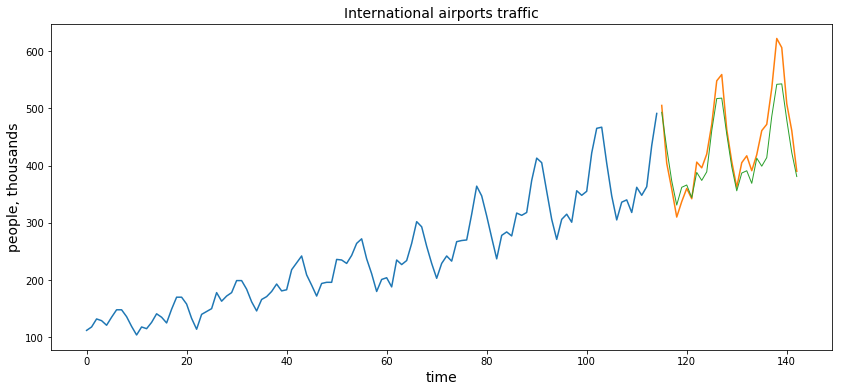

In [136]:
a = np.arange(test_size + train_size)
plt.figure(figsize=(14,6))
plt.plot(a[:train_size], y, label="train")
plt.plot(a[-test_size:], y_test, label="test")
plt.plot(a[-test_size:], y_test_pred, lw=1, label="predicted")
plt.title("International airports traffic", fontsize=14)
plt.ylabel("people, thousands", fontsize=14)
plt.xlabel("time", fontsize=14)
save('11_long_term')
plt.show()

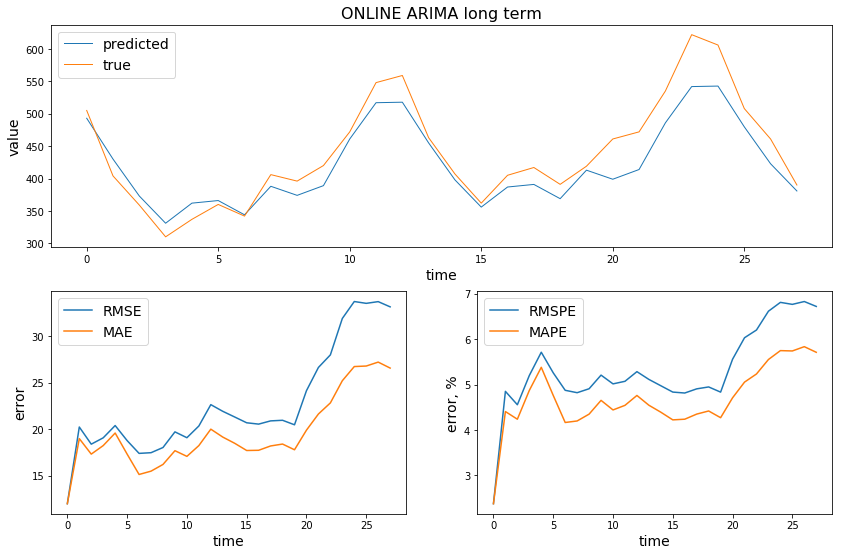

In [138]:
getNplot_errors(y_test, y_test_pred,'ONLINE ARIMA long term')